In [13]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import joblib

os.makedirs('D:/Projects/review-rating-system/ml_model/plots', exist_ok=True)
os.makedirs('D:/Projects/review-rating-system/ml_model/deep_models', exist_ok=True)

In [3]:
df_bal = pd.read_csv('D:/Projects/review-rating-system/ml_model/data/balanced_reviews.csv')
df_imb = pd.read_csv('D:/Projects/review-rating-system/ml_model/data/imbalanced_reviews.csv')

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_bal['clean_text'] = df_bal['text'].apply(clean_text)
df_imb['clean_text'] = df_imb['text'].apply(clean_text)

Padding and Tokenizing

In [14]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(pd.concat([df_bal['clean_text'], df_imb['clean_text']]))

def prepare_data(df):
    sequences = tokenizer.texts_to_sequences(df['clean_text'])
    padded = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')
    labels = to_categorical(df['rating'] - 1)
    return padded, labels

X_bal, y_bal = prepare_data(df_bal)
X_imb, y_imb = prepare_data(df_imb)

Train-Test Split

In [15]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(X_imb, y_imb, test_size=0.2, random_state=42)

print(f"Balanced → Train: {X_train_bal.shape[0]}, Test: {X_test_bal.shape[0]}")
print(f"Imbalanced → Train: {X_train_imb.shape[0]}, Test: {X_test_imb.shape[0]}")

Balanced → Train: 4000, Test: 1000
Imbalanced → Train: 4800, Test: 1200


Model Building

In [16]:
def build_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=200),
        Bidirectional(LSTM(64)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Training on balanced 

In [18]:
model_bal = build_model()
history_bal = model_bal.fit(X_train_bal, y_train_bal, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.2059 - loss: 1.6081 - val_accuracy: 0.2775 - val_loss: 1.5928
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.2966 - loss: 1.5698 - val_accuracy: 0.3038 - val_loss: 1.5076
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.3709 - loss: 1.4035 - val_accuracy: 0.3938 - val_loss: 1.3630
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.4597 - loss: 1.2047 - val_accuracy: 0.4075 - val_loss: 1.3386
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.5584 - loss: 1.0280 - val_accuracy: 0.4250 - val_loss: 1.3465
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.6300 - loss: 0.8672 - val_accuracy: 0.4200 - val_loss: 1.4888
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.6969 - loss: 0.7495 - val_accuracy: 0.4238 - val_loss: 1.6622
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.7684 - loss: 0.6106 - val_accuracy: 0.4100 - v

Training on imbalanced

In [20]:
model_imb = build_model()

# Compute class weights
y_labels = np.argmax(y_train_imb, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_labels), y=y_labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Train with class weights
history_imb = model_imb.fit(X_train_imb, y_train_imb,
                            epochs=10,
                            batch_size=128,
                            validation_split=0.2,
                            class_weight=class_weights_dict)

Class Weights: {0: np.float64(5.714285714285714), 1: np.float64(3.076923076923077), 2: np.float64(1.9672131147540983), 3: np.float64(1.4791987673343605), 4: np.float64(0.3016022620169651)}
Epoch 1/10


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.3495 - loss: 1.6056 - val_accuracy: 0.5271 - val_loss: 1.5321
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5219 - loss: 1.5676 - val_accuracy: 0.5094 - val_loss: 1.4388
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5661 - loss: 1.4334 - val_accuracy: 0.5437 - val_loss: 1.1488
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5557 - loss: 1.3014 - val_accuracy: 0.5917 - val_loss: 1.0636
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5979 - loss: 1.0666 - val_accuracy: 0.5042 - val_loss: 1.1870
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.6518 - loss: 0.8607 - val_accuracy: 0.5323 - val_loss: 1.2223
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7156 - loss: 0.6583 - val_accuracy: 0.5292 - val_loss: 1.2993
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7576 - loss: 0.5340 - val_accuracy: 0.4354 - val_loss: 1.

Visualisation and Evaluation

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
📊 Classification Report (balanced):

              precision    recall  f1-score   support

           0      0.567     0.379     0.454       190
           1      0.312     0.250     0.277       192
           2      0.364     0.435     0.397       216
           3      0.364     0.381     0.372       210
           4      0.473     0.594     0.527       192

    accuracy                          0.408      1000
   macro avg      0.416     0.408     0.405      1000
weighted avg      0.413     0.408     0.404      1000



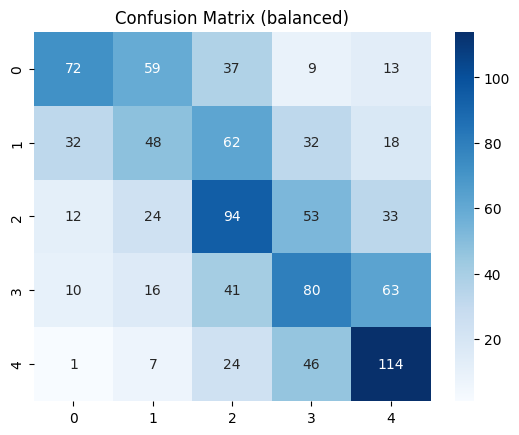

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
📊 Classification Report (imbalanced):

              precision    recall  f1-score   support

           0      0.294     0.312     0.303        32
           1      0.346     0.205     0.257        88
           2      0.248     0.304     0.273       112
           3      0.177     0.397     0.245       151
           4      0.839     0.655     0.735       817

    accuracy                          0.547      1200
   macro avg      0.381     0.375     0.363      1200
weighted avg      0.650     0.547     0.584      1200



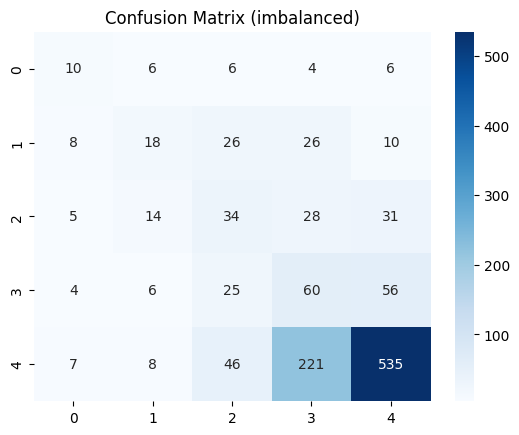

In [21]:
def evaluate_model(model, X_test, y_test, label):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print(f"📊 Classification Report ({label}):\n")
    print(classification_report(y_true, y_pred_classes, digits=3))

    sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({label})')
    plt.savefig(f'ml_model/plots/confusion_matrix_bilstm_{label}.png')
    plt.show()

evaluate_model(model_bal, X_test_bal, y_test_bal, 'balanced')
evaluate_model(model_imb, X_test_imb, y_test_imb, 'imbalanced')

Saving model and tokenizer

In [25]:
model_bal.save('D:/Projects/review-rating-system/ml_model/deep_models/bilstm_model_balanced.h5')
model_imb.save('D:/Projects/review-rating-system/ml_model/deep_models/bilstm_model_imbalanced.h5')
joblib.dump(tokenizer, 'D:/Projects/review-rating-system/ml_model/deep_models/tokenizer_bilstm.pkl')

['D:/Projects/review-rating-system/ml_model/deep_models/tokenizer_bilstm.pkl']